In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pubchempy as pcp

In [2]:
def cid_to_smiles(cid):
    try:
        mol = pcp.Compound.from_cid(int(cid))
        if mol:
            smile = mol.isomeric_smiles
            return smile
    except:
        pass
    return float('nan')

In [3]:
nci = pd.read_csv("../raw/NCI60/IC50.csv")
nci = nci.loc[nci["CONCENTRATION_UNIT"] == 'M'][['NSC','PANEL_CODE','CELL_NAME', 'AVERAGE']]
nci.head()

,NSC,PANEL_CODE,CELL_NAME,AVERAGE
0,123127,LNS,NCI-H460,-8.1196
1,123127,MEL,M14,-6.7945
2,123127,CNS,SF-539,-6.6120
3,123127,COL,COLO 205,-6.3511
4,123127,COL,SW-620,-6.5272


In [4]:
nci = nci.groupby(['NSC', 'CELL_NAME', 'PANEL_CODE']).agg({'AVERAGE': 'mean'}).reset_index()
len(nci)

3230120

In [5]:
nci_gdsc_codes = pd.read_csv("../processed/nci_codes.csv")
nci_gdsc_codes = nci_gdsc_codes.rename(columns={"nci": "CELL_NAME", "gdsc":"gdsc_name"})
nci_gdsc_codes.head()

,CELL_NAME,gdsc_name
0,MCF7,MCF7
1,MDA-MB-231/ATCC,MDA-MB-231
2,HS 578T,NaN
3,BT-549,BT-549
4,T-47D,T47D


In [6]:
nsc_smiles = pd.read_csv("../raw/NCI60/nsc_sid_cid.csv")
nsc_smiles = nsc_smiles.dropna(subset='CID')
nsc_smiles.head()

,NSC,SID,CID
0,1,66954,11122.0
1,2,66955,8447.0
2,3,66956,13681.0
3,4,66957,8486.0
4,5,66958,8341.0


In [7]:
nci_prep = pd.merge(nci, nci_gdsc_codes, on='CELL_NAME', how='inner')
nci_prep = pd.merge(nci_prep, nsc_smiles, on='NSC', how='inner')
nci_prep = nci_prep.dropna(subset=["gdsc_name"])
nci_prep['AVERAGE'] = nci_prep.loc[:, 'AVERAGE'].apply(lambda x : -x - 6)
nci_prep['AVERAGE'] = nci_prep.loc[:, 'AVERAGE'].clip(lower=-4, upper=4)
nci_prep.head()

,NSC,CELL_NAME,PANEL_CODE,AVERAGE,gdsc_name,SID,CID
1,1,A498,REN,-2.116533,A498,66954,11122.0
2,1,A549/ATCC,LNS,-1.725633,A549,66954,11122.0
3,1,ACHN,REN,-0.974133,ACHN,66954,11122.0
4,1,BT-549,BRE,-1.524467,BT-549,66954,11122.0
5,1,CAKI-1,REN,-1.445300,CAKI-1,66954,11122.0


In [8]:
cid_smiles = pd.DataFrame({'CID':nci_prep['CID'].unique()})
cid_smiles['smiles'] = cid_smiles['CID'].apply(cid_to_smiles)
cid_smiles = cid_smiles.dropna()
len(cid_smiles)

55177

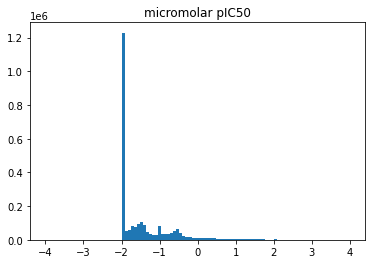

In [9]:
plt.hist(nci_prep['AVERAGE'], bins=100)
plt.title("micromolar pIC50")
plt.show()

In [10]:
nci_prep_smiles = pd.merge(nci_prep, cid_smiles, on="CID", how="inner")
nci_prep_smiles.rename(columns={
    "AVERAGE": "pIC50",
    "SMILES":"smiles",
    "PANEL_CODE": "panel",
    "gdsc_name": "cell_line"
}, inplace=True)
nci_prep_smiles = nci_prep_smiles[pd.notna(nci_prep_smiles["smiles"])]
nci_final = nci_prep_smiles[["cell_line", "panel", "smiles", "pIC50"]]
nci_final.head()

,cell_line,panel,smiles,pIC50
0,A498,REN,CC1=CC(=O)C=CC1=O,-2.116533
1,A549,LNS,CC1=CC(=O)C=CC1=O,-1.725633
2,ACHN,REN,CC1=CC(=O)C=CC1=O,-0.974133
3,BT-549,BRE,CC1=CC(=O)C=CC1=O,-1.524467
4,CAKI-1,REN,CC1=CC(=O)C=CC1=O,-1.445300


In [12]:
nci_final.to_csv("../processed/nci_cdr.csv", index=False)